In [1]:
#import the necessary datasets.

#selenium for controlling the browser
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.support import expected_conditions

#libraries for interacting with dataframes in python
import pandas as pd
import lxml
#bs4 for scraping text from the page
from bs4 import BeautifulSoup
#I always import os for operating system and file management
import os
import time
import re
#if you haven't already insteall nltk, then run this:
#import nltk
#nltk.download() #This will download all the nltk corpuses.  This may take a while to download.
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
#from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from string import punctuation
import pprint as pp

# Consumers Energy Job Posting Text Exploration
##### R. Abram Beyer
##### The purpose of this project is to demonstrate web scraping, data wrangling and basic exploratory analysis using data from the web.  
#### In order to scrape the web data, I am also using browser automation software.


## Web Scraping and Browser Automation
##### First open Chrome, open the Consumer's Energy careers webpage.  

In [13]:
#initialize the browser.
browser = webdriver.Chrome()

In [14]:
#connect to cms careers website
browser.get('https://www.consumersenergy.com/company/careers')

In [15]:
#make the browser window full screen
browser.maximize_window()

##### Click on the actual job list page

In [16]:
#click the "Search for Jobs or Apply Now button"
browser.find_element_by_xpath('/html/body/div[5]/div[3]/div/div[5]/div/div/div[2]/a').click()

##### Create a list of the pagination links so you can open all job listing pages

In [17]:
#get all the href items under the pagination class.
#this will give you a list of the 'page-turning' links in the top right corner of the page so 
#you can flip through all the job listing pages.
pagination_url_list = list(set([el.get_attribute("href") for el in browser.find_elements_by_xpath("//ul[@class='pagination']/li/a")]))

In [18]:
#create an empty dataframe to store results in.
job_link_df = pd.DataFrame(columns=['job_title', 'href'])

##### Loop over the pagination links, open the job listing page, extract all the job titles and job listing hyperlinks.

In [19]:
#loop over all pagination hrefs to turn the page of job listings.
for i, item in enumerate(pagination_url_list):
    time.sleep(1)
    #open the link.
    browser.get(item)
    #download the page source
    html = browser.page_source
    #parse the html
    soup = BeautifulSoup(html,'html.parser')
    #find all href tags on the page with the class 'jobtitle-link'
    job_titles = soup.find_all('a', {'class': 'jobTitle-link'})
    #loop over all href jobtitles and append to the dataframe.
    for i, item in enumerate(job_titles):
        job_link_df = job_link_df.append({'job_title': item.text, 'href': item['href']}, ignore_index=True)
    #For some reason the links and titles are duplicated in the source.  drop duplicates.
    job_link_df = job_link_df.drop_duplicates()

##### We don't care about all the job listings.  Just the ones I know could be related to data analytics.  

In [20]:
#filter the job listings.
#I only care about analytics/data science related postings.

#Analyst
#Reporting
#Data Scientist
#Data
#Tech
#BUS SPRT CNSL
#Analytics

job_link_df = job_link_df[((job_link_df['job_title'].str.lower().str.contains('analyst')) | \
            (job_link_df['job_title'].str.lower().str.contains('reporting')) | \
            (job_link_df['job_title'].str.lower().str.contains('data')) | \
            (job_link_df['job_title'].str.lower().str.contains('data scientist')) | \
            (job_link_df['job_title'].str.lower().str.contains('tech')) | \
            (job_link_df['job_title'].str.lower().str.contains('bus sprt cnsl')) | \
            (job_link_df['job_title'].str.lower().str.contains('analytics'))) & \
            ~(job_link_df['job_title'].str.lower().str.contains('technician'))]

In [21]:
job_link_df['job_description'] = None

##### For each job listing in the dataframe, open the url, and extract all the job listing text.  Then do a little initial cleaning.

In [22]:
#add empty placeholder column for the job text
job_link_df['job_description'] = None


for i, row in job_link_df.iterrows():
    #open the page
    browser.get('https://careers.consumersenergy.com' + row['href'])
    #give it a second
    time.sleep(1)
    #download the page source
    html = browser.page_source
    #parse the html
    soup = BeautifulSoup(html,'html.parser')
    #only want text under the 'job' div.  This div holds mostly the job description.
    job_div = soup.find_all("div", {"class":"job"})
    #extract the text from that div.
    #initialize empty string for text_output
    text_output = ''
    #list of items to filter out.
    dontwantlist = [
        'All qualified applicants will not be discriminated against and will receive consideration for employment without regard to protected veteran status, disability, race, color, religion, sex, sexual orientation, gender identity or national origin.',
         'Position will be filled at the appropriate salary grade based upon the skills, knowledge, and experience of the selected candidate.',
        'The physical demands described here are representative of those that must be met by an employee to successfully perform the essential functions of this job. Reasonable accommodations may be made to enable individuals with disabilities to perform the essential functions.\xa0 While performing the duties of this job, the employee is regularly required to sit; stand; walk; and stoop, kneel, crouch, or crawl; use hands to finger, handle, or feel objects, tools, or controls; and reach with hands and arms. The employee frequently is required to talk or hear.\xa0\xa0 The employee must frequently lift and move up to ten pounds and occasionally lift and move up to fifty pounds. Specific vision abilities required by this job include close vision, color vision, depth perception, and the ability to adjust focus.\xa0 The work environment characteristics described here are representative of those an employee encounters while performing the essential functions of this job. The noise level in the work environment is usually moderate. The noise level on the construction site is often loud. ',
        '\n',
        'xa0',
        "Join a diverse and dynamic team that makes and delivers the most valuable services in the world: electricity and natural gas.\xa0 At Consumers Energy, our customers are at the heart of everything we do.\xa0 Our employees work around the clock to provide service to our customers in honor of our history and to fulfill our promise to Michigan - Count on Us!\xa0 Consumers Energy, the principal subsidiary of CMS Energy and headquartered in Jackson, Michigan, provides natural gas and electricity to nearly 6.8 million of\xa0Michigan's 10 million residents in all 68 Lower Peninsula counties.", 
        'Job Description',
        'Responsibilities',
        'Skills and Qualifications',
        'Position Summary',
        'Department Summary'

    ]
    #iterate over the text list items from the job description div.
    #if the text is not in the blacklist, then 
    #do some data cleaning.  
    for t in job_div[0].find_all(text=True):
        if t not in dontwantlist:
            #do some basic clean up.  remove xao, new line symbol, and convert to lowercase and strip out leading white space.
            #use .lower() because nltk stopwords list is already in lowercase()
            text_output += '{} '.format(t.replace('xa0','').replace('\xa0','').replace('\n','').lower().lstrip().rstrip())
    text_output = text_output.lstrip().rstrip()
    #more cleanup
    text_output = text_output.replace('job description','').\
                              replace('responsibilities','').\
                              replace('skills and qualifications','').\
                              replace('department summary','').\
                              replace('position summary','').\
                              replace("consumers energy company's",'').\
                              replace("consumers energy",'').\
                              replace("the successful candidate will",'').\
                              replace("join a diverse and dynamic team that makes and delivers the most valuable services in the world: electricity and natural gas. at , our customers are at the heart of everything we do. our employees work around the clock to provide service to our customers in honor of our history and to fulfill our promise to michigan - count on us! , the principal subsidiary of cms energy and headquartered in jackson, michigan, provides natural gas and electricity to nearly 6.8 million of the michigan's 10 million residents in all 68 lower peninsula counties",'')
    
    #set the job_description column row to the text
    job_link_df.at[i,'job_description'] = text_output

### Which job title descriptions did we get?

In [23]:
#group by count the job titles.  
job_link_df['job_title'].value_counts()

Senior Environmental Analyst                                                                      2
Data Visualization Analyst                                                                        1
Data Analytics                                                                                    1
Information Technology/Computer Science Intern/Co-Op                                              1
SAP Technical Analyst - Billing and Device Management                                             1
Customer Intelligence & Analytics Data Scientist                                                  1
Application Security Analyst                                                                      1
Marketing Operations Analyst                                                                      1
Security Risk Analyst                                                                             1
Analytics Translator                                                                              1


## Data Cleaning

#### Now we have a dataframe of job titles and job descriptions.  Next, clean the data and prepare for text analysis.
#### First tokenize the job descriptions
#### Some inspiration for this section:  https://towardsdatascience.com/getting-started-with-text-analysis-in-python-ca13590eb4f7

In [24]:
job_link_df['job_description_tokenized'] = job_link_df['job_description'].apply(word_tokenize)
job_link_df['job_description_tokenized'].head(n=10)

0     [the, customer, intelligence, &, analytics, te...
11    [the, security, risk, analyst, is, performing,...
12    [the, instrumentation, and, controls, (, i, &,...
15    [this, position, is, within, the, instrumentat...
19    [join, a, diverse, and, dynamic, team, that, m...
31    [., the, information, technology, (, it, ), in...
38    [cms, enterprises, owns, and, operates, indepe...
39    [accounting, policy, &, external, financial, r...
42    [company, ’, s, environmental, services, depar...
43    [company, ’, s, environmental, services, depar...
Name: job_description_tokenized, dtype: object

#### Next remove stop words from the tokenized word lists

In [25]:
#apply English stop word removal from all tokenized text.
stopwordlist = stopwords.words('english')

In [26]:
#remove stop words
job_link_df['job_description_tokenized'] = job_link_df['job_description_tokenized'].apply(lambda x: [item for item in x if item not in stopwordlist])

##### We only want letters.  Remove punctuation

In [27]:
#only include letters
job_link_df['job_description_tokenized'] = job_link_df['job_description_tokenized'].apply(lambda x: [re.sub("[^a-zA-Z]", " ", item) for item in x])

In [28]:
#check again by making sure no characters are in the string library punctuation list
job_link_df['job_description_tokenized'] = job_link_df['job_description_tokenized'].apply(lambda x: [item for item in x if item not in punctuation])

In [29]:
#remove blank strings
job_link_df['job_description_tokenized'] = job_link_df['job_description_tokenized'].apply(lambda x: [item for item in x if item != ' '])

In [30]:
#do left trim and right trim again just to be safe.
job_link_df['job_description_tokenized'] = job_link_df['job_description_tokenized'].apply(lambda x: [item.lstrip().rstrip() for item in x])

In [31]:
#### There are some common words I'd like to remove
also_dont_want_list = ['work','job','may','','company','employees','employee','candidate','role','individual','user','required',\
                       'essential','optional','and or','new','must','customer','work','works','including','segment','provide',\
                       'requirement','requirements','skill','skills','ability','include','position','nearest','functions','perform','requires']
#remove these common job description words that don't add value.
job_link_df['job_description_tokenized'] = job_link_df['job_description_tokenized'].apply(lambda x: [item for item in x if item not in also_dont_want_list])

## Visualizing At  A High Level

##### Things are pretty clean now.  Let's take a quick look at overall word counts

In [32]:
analyst_word_list = []
for i, item in job_link_df.iterrows():
    analyst_word_list += item['job_description_tokenized']

In [33]:
#count the words in the bag of words
overall_words_collection = nltk.FreqDist(analyst_word_list)

### How many distinct words are their in the job descriptions?

In [34]:
print('There are',str(len(overall_words_collection)),'in the analyst job description vocabulary.')

There are 1792 in the analyst job description vocabulary.


### What are the top 50 most common words in analytics-related job descriptions?

In [35]:
#let's look at the most common 200 words in the bag of words
top_200_words = pd.DataFrame.from_dict(overall_words_collection.most_common(50))
#give the dataframe proper names
top_200_words = top_200_words.rename(columns={0: "word", 1: "count"})

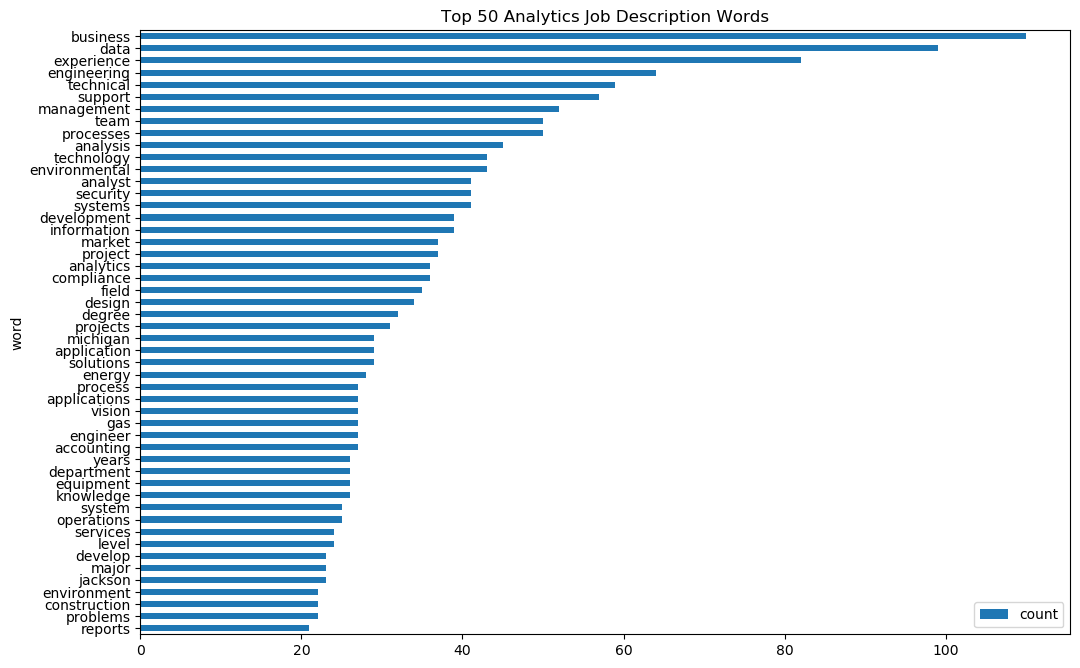

In [36]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 
top_200_words.sort_values(by='count',ascending=1).plot.barh(x='word', y='count', rot=0)
plt.title('Top 50 Analytics Job Description Words')
plt.show()

### What is Consumers Energy looking for in an Analyst?  
### What are the top 50 most common verbs in the text?

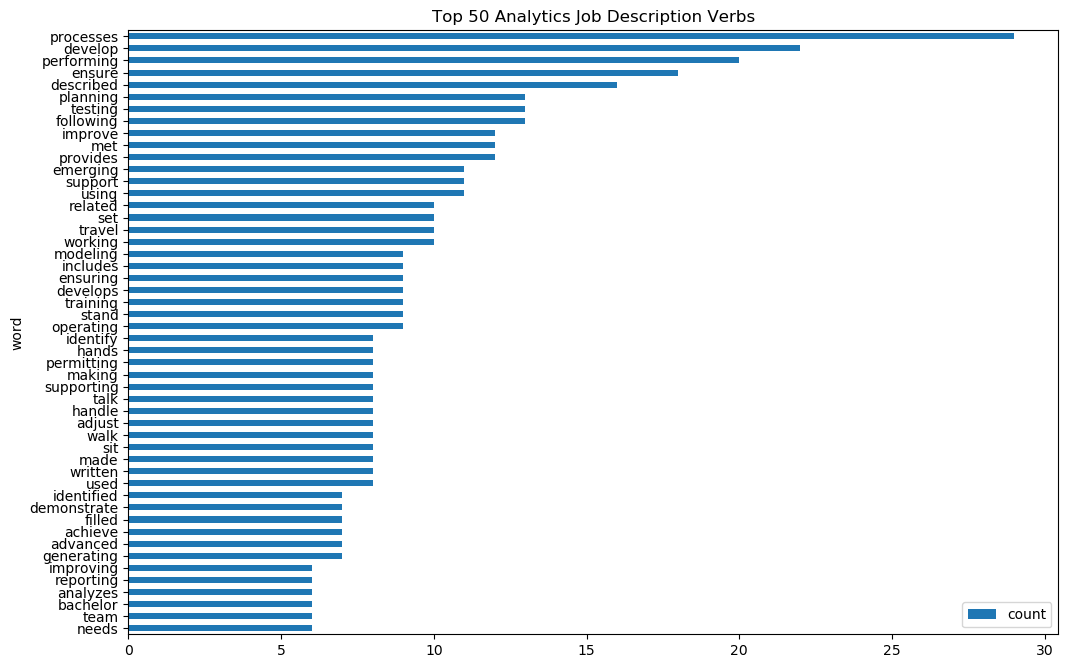

In [37]:
verb_word_list = [item[0] for item in nltk.pos_tag(analyst_word_list,tagset='universal') if item[1] == 'VERB']
top_50_analyst_verbs = pd.DataFrame.from_dict(nltk.FreqDist(verb_word_list).most_common(50))
top_50_analyst_verbs = top_50_analyst_verbs.rename(columns={0: "word", 1: "count"})
#viz
top_50_analyst_verbs.sort_values(by='count',ascending=1).plot.barh(x='word', y='count', rot=0,title='Top 50 Analytics Job Description Verbs')


### What are the top 50 most common adjectives in the text?

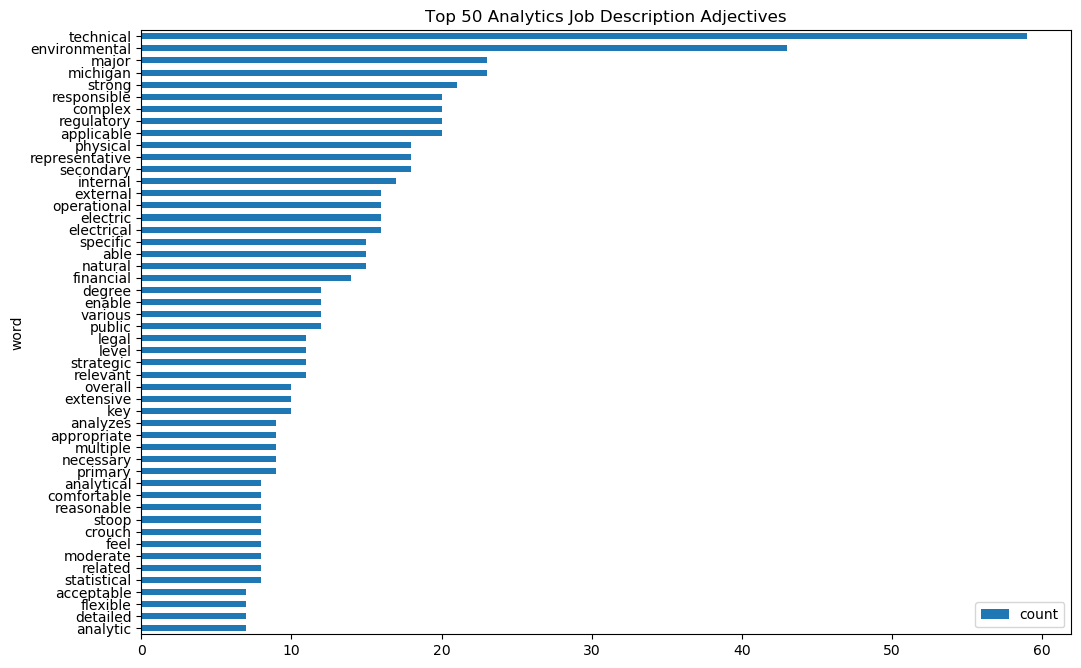

In [38]:
adj_word_list = [item[0] for item in nltk.pos_tag(analyst_word_list,tagset='universal') if item[1] == 'ADJ']
top_50_analyst_adj = pd.DataFrame.from_dict(nltk.FreqDist(adj_word_list).most_common(50))
top_50_analyst_adj = top_50_analyst_adj.rename(columns={0: "word", 1: "count"})
#viz
top_50_analyst_adj.sort_values(by='count',ascending=1).plot.barh(x='word', y='count', rot=0,title='Top 50 Analytics Job Description Adjectives')


### Word Cloud
##### Not really all that interesting yet.  Let's try a word cloud to get an overall idea of the text.

In [39]:
all_words_string = " ".join(analyst_word_list)

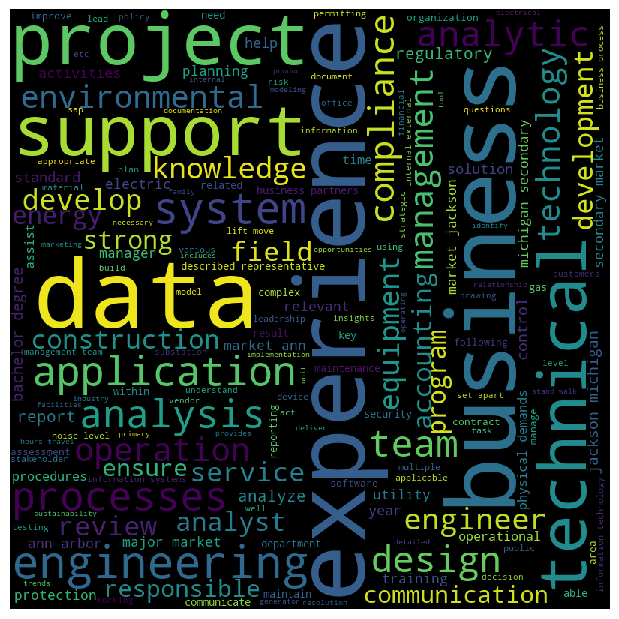

In [40]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(all_words_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### Let's compare some common data-related ideas and technologies and see how often these words appear in the vocabulary

In [41]:
analyst_text = nltk.Text(analyst_word_list)

### Python appears more than R.  PowerBi appears twice while Tableau appears 3 times.  SQL appears several times.

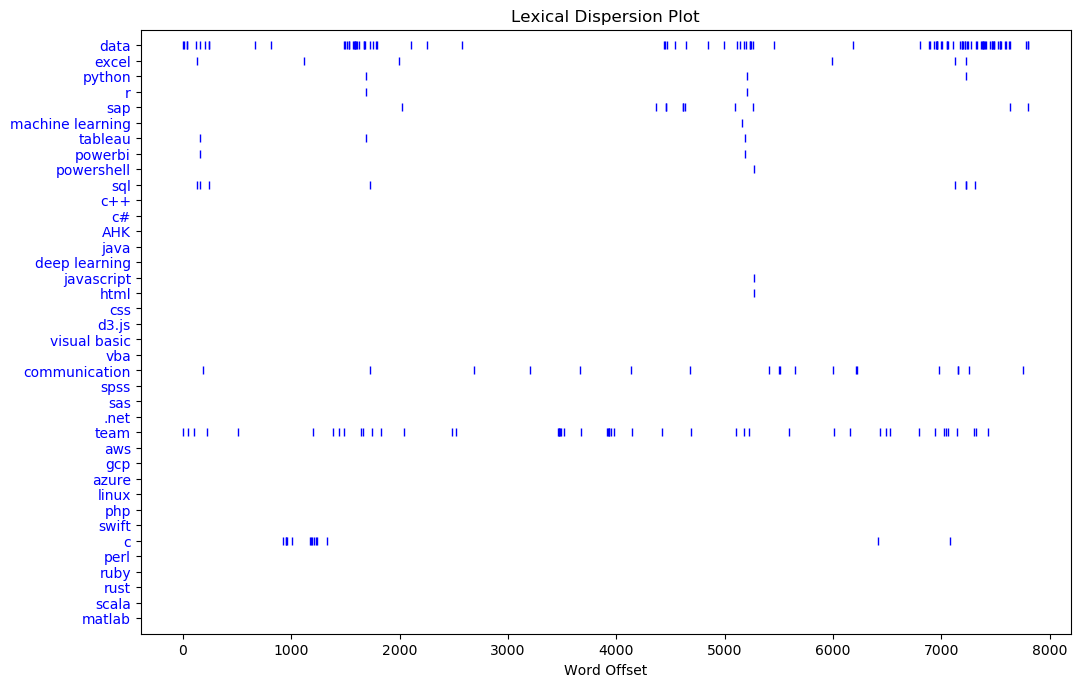

In [42]:
analyst_text.dispersion_plot(['data','excel',\
                              'python','r','sap',\
                              'machine learning','tableau',\
                              'powerbi','powershell','sql',\
                              'c++','c#','AHK','java','deep learning',\
                             'javascript','html','css','d3.js','visual basic','vba',
                             'communication','spss','sas','.net','team','aws','gcp','azure','linux',
                             'php','swift','c','perl','ruby','rust','scala','matlab'])